In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# data_IO_C_all.to_csv('data_IO_C_all.csv',index=False)
data_IO_C_all=pd.read_csv('data_IO_C_all.csv')
data_IO_C_all.head()

,date,IF_close,code,strike,IOIF_delta_price,exp_day,IO_close
0,2020-01-20,4194.8,IO2002-C-3550,3550,-644.8,32,643.8
1,2020-01-20,4194.8,IO2002-C-3600,3600,-594.8,32,594.0
2,2020-01-20,4194.8,IO2002-C-3650,3650,-544.8,32,553.2
3,2020-01-20,4194.8,IO2002-C-3700,3700,-494.8,32,506.4
4,2020-01-20,4194.8,IO2002-C-3750,3750,-444.8,32,457.0


# 用LSTM来拟合CALL_STL_PRICE和PUT_STL_PRICE

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

def LoadData(df, sequence_length):
    features = df[['IF_close', 'IOIF_delta_price', 'exp_day']].values
    labels = df['IO_close'].values

    # 数据标准化
    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    # 创建序列
    X = create_sequences(features, sequence_length)
    y = labels[sequence_length-1:]

    # 划分数据集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=False)
    
    # 转换为PyTorch张量
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # DataLoader
    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)
    test_data = TensorDataset(X_test, y_test)

    Batch_size = 64
    
    train_loader = DataLoader(train_data, batch_size=Batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=Batch_size)
    test_loader = DataLoader(test_data, batch_size=Batch_size)
    
    return train_loader, val_loader, test_loader

In [4]:
import torch.nn as nn

In [5]:
#定义参数的CLASS
class Args():
    def __init__(self):
        self.lr=0.01
        self.num_epochs=150
        self.best_val_loss=float('inf')
        self.device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f'Using {self.device}')
        self.criterion=nn.MSELoss()
        self.optimizer=torch.optim.Adam(model.parameters(), lr=0.01)
        #self.scheduler=ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, min_lr=1e-6, verbose=True)

In [6]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
def train(model, train_loader, val_loader, args):
    torch.autograd.set_detect_anomaly(True)
    print(f'Training on {args.device}...')
    model.to(args.device)
    criterion = args.criterion
    optimizer = args.optimizer
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, min_lr=1e-7, verbose=True)

    num_epochs = args.num_epochs
    best_val_loss = args.best_val_loss

    early_stop_patience = 10  # 设置早停
    epochs_no_improve = 0 

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(args.device), targets.to(args.device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        total_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(args.device), targets.to(args.device)
                outputs = model(inputs)
                outputs = outputs.squeeze(1)
                loss = criterion(outputs, targets)
                total_loss += loss.item()

        avg_val_loss = total_loss / len(val_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {avg_val_loss:.4f}')

        # 更新 scheduler
        scheduler.step(avg_val_loss)

        # 保存最好的模型，并检查早停条件
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            
        # 检查是否达到早停条件
        if epochs_no_improve == early_stop_patience:
            print(f'Early stopping triggered after {epoch + 1} epochs!')
            break
    print("模型训练完成！")
    return model

In [7]:
# 模型评估
def TEST(test_loader,args,model):
    print(f'Testing on {args.device}...')
    model.to(args.device)
    criterion=args.criterion
    model.eval()  
    total_loss = 0.0
    
    with torch.no_grad():  # 在评估阶段不计算梯度
        for inputs, targets in test_loader:
            # 将数据移动到GPU上
            inputs,targets = inputs.to(args.device),targets.to(args.device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            total_loss += loss.item()
            
    #绘图和计算误差
    model.eval()  
    predictions = []
    actuals = []
    for inputs, targets in test_loader:
        inputs,targets = inputs.to(args.device),targets.to(args.device)
        outputs = model(inputs)
        predictions.extend(outputs.view(-1).tolist())
        actuals.extend(targets.tolist())
        
    # 转换为numpy数组以便绘图
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # 可视化1: 真实值与预测值的对比
    plt.figure(figsize=(12, 6))
    plt.plot(actuals[-300:], label='true', color='blue')
    plt.plot(predictions[-300:], label='pred', color='red')
    plt.title('Label: true vs pred')
    plt.xlabel('date')
    plt.ylabel('IO_close')
    plt.legend()
    plt.show()
    
    # 可视化2: 预测误差的分布
    errors = actuals - predictions
    plt.figure(figsize=(12, 6))
    plt.hist(errors, bins=50, color='gray')
    plt.title('pred_erro_distribution')
    plt.xlabel('pred_error')
    plt.ylabel('counts')
    plt.show()
    
    # 将测试集的实际值和预测值转换为numpy数组（如果它们还不是的话）
    actuals_np = np.array(actuals)  
    predictions_np = np.array(predictions)  
    results_df = pd.DataFrame({'y_test': actuals_np,'y_test_pred': predictions_np})
    # 显示DataFrame的前几行
    print("\n展示部分test_set上的拟合效果")
    print(results_df.head())
    print('\n')
    print(f'测试集平均损失: {total_loss/len(test_loader):.4f}\n')
    return results_df

In [8]:
import torch
import torch.nn as nn

class LSTMResNet(nn.Module):
    def __init__(self, num_features, hidden_size, num_layers, output_size):
        super(LSTMResNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=num_features, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

        # Residual connection
        self.shortcut = nn.Sequential(
            nn.Linear(num_features, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        # Initial hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Take the output of the last time step
        out = out[:, -1, :]
        
        # Residual connection
        residual = self.shortcut(x[:, -1, :])
        
        # Final output
        out = self.fc(out) + residual
        return out


In [9]:
model = LSTMResNet(num_features=3, hidden_size=64, num_layers=2, output_size=1)

Using cuda
Training on cuda...
Epoch [1/150], Training Loss: 77699.3554, Validation Loss: 3379.4936
Epoch [2/150], Training Loss: 2983.1248, Validation Loss: 394.9000
Epoch [3/150], Training Loss: 350.3524, Validation Loss: 222.4154
Epoch [4/150], Training Loss: 172.4357, Validation Loss: 132.8069
Epoch [5/150], Training Loss: 137.2103, Validation Loss: 87.0572
Epoch [6/150], Training Loss: 118.9209, Validation Loss: 74.5050
Epoch [7/150], Training Loss: 107.7312, Validation Loss: 62.0414
Epoch [8/150], Training Loss: 101.2783, Validation Loss: 63.4670
Epoch [9/150], Training Loss: 97.8727, Validation Loss: 63.3432
Epoch [10/150], Training Loss: 95.6487, Validation Loss: 51.9202
Epoch [11/150], Training Loss: 94.8809, Validation Loss: 74.5758
Epoch [12/150], Training Loss: 94.1785, Validation Loss: 61.8961
Epoch [13/150], Training Loss: 94.0801, Validation Loss: 67.2277
Epoch [14/150], Training Loss: 94.0631, Validation Loss: 48.1975
Epoch [15/150], Training Loss: 93.8255, Validation L

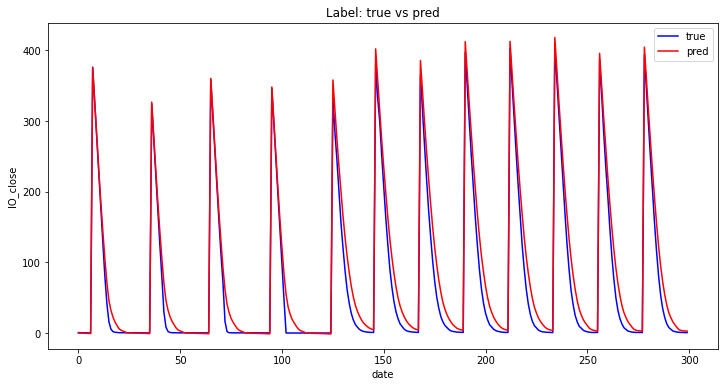

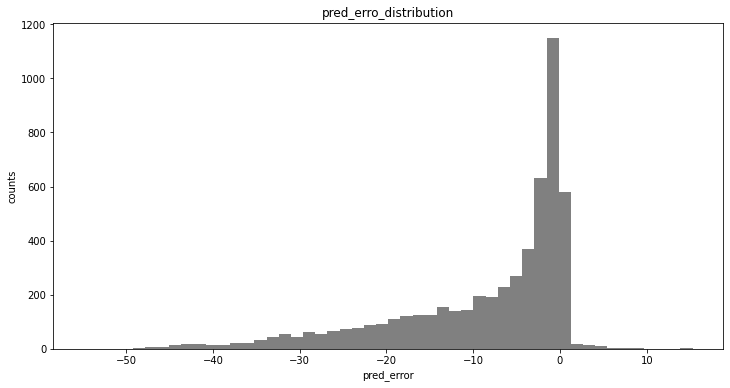


展示部分test_set上的拟合效果
        y_test  y_test_pred
0  1007.599976  1011.758606
1   907.799988   911.991516
2   808.000000   812.223572
3   708.200012   711.909485
4   658.400024   662.006470


测试集平均损失: 184.0323



,y_test,y_test_pred
0,1007.599976,1011.758606
1,907.799988,911.991516
2,808.000000,812.223572
3,708.200012,711.909485
4,658.400024,662.006470
...,...,...
5426,1.000000,4.704983
5427,0.800000,3.615067
5428,0.800000,3.017323
5429,0.600000,2.811836


In [10]:
train_loader,va_loader,test_loader=LoadData(data_IO_C_all,sequence_length=10)
args=Args()
model=train(model,train_loader,va_loader,args)
TEST(test_loader,args,model)

In [11]:
import torch
import torch.nn as nn

class LSTMBlock(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMBlock, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    
    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        return out

class ResidualLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(ResidualLSTM, self).__init__()
        self.lstm_block = LSTMBlock(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(input_size, hidden_size)
    
    def forward(self, x):
        residual = self.linear(x)
        out = self.lstm_block(x)
        out = out+residual
        return out

In [12]:
class LSTMResNet(nn.Module):
    def __init__(self, num_features, hidden_size, num_residual_blocks, num_layers, output_size):
        super(LSTMResNet, self).__init__()
        self.num_residual_blocks = num_residual_blocks
        self.num_layers=num_layers
        self.hidden_size=hidden_size
        # 初始的LSTM块
        self.initial_lstm = nn.LSTM(input_size=num_features, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # 构建残差块序列
        self.residual_blocks = nn.ModuleList([ResidualLSTM(hidden_size, hidden_size) for _ in range(num_residual_blocks)])
        
        # 输出层
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 初始LSTM处理
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.initial_lstm(x, (h0, c0))

        # 通过残差块序列
        for block in self.residual_blocks:
            out = block(out)
        
        # 取最后一个时间步的输出
        out = out[:, -1, :]
        
        # 输出层
        out = self.fc(out)
        return out

Using cuda
Training on cuda...
Epoch [1/150], Training Loss: 11622.0928, Validation Loss: 490.6009
Epoch [2/150], Training Loss: 2112.8742, Validation Loss: 1979.4888
Epoch [3/150], Training Loss: 420.4352, Validation Loss: 196.5411
Epoch [4/150], Training Loss: 322.1718, Validation Loss: 129.8082
Epoch [5/150], Training Loss: 328.0457, Validation Loss: 306.9677
Epoch [6/150], Training Loss: 791.1406, Validation Loss: 105.0242
Epoch [7/150], Training Loss: 786.2029, Validation Loss: 232.7876
Epoch [8/150], Training Loss: 315.1541, Validation Loss: 205.4222
Epoch [9/150], Training Loss: 1474.1829, Validation Loss: 816.3496
Epoch [10/150], Training Loss: 761.2681, Validation Loss: 454.8813
Epoch [11/150], Training Loss: 144.8564, Validation Loss: 82.7382
Epoch [12/150], Training Loss: 198.2772, Validation Loss: 540.5001
Epoch [13/150], Training Loss: 254.8416, Validation Loss: 99.0069
Epoch [14/150], Training Loss: 192.2230, Validation Loss: 84.2948
Epoch [15/150], Training Loss: 723.098

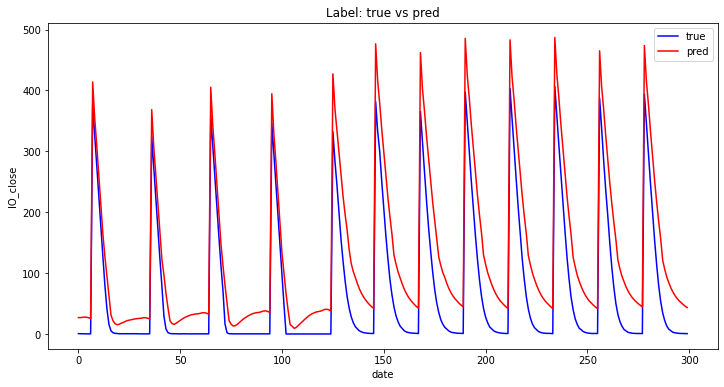

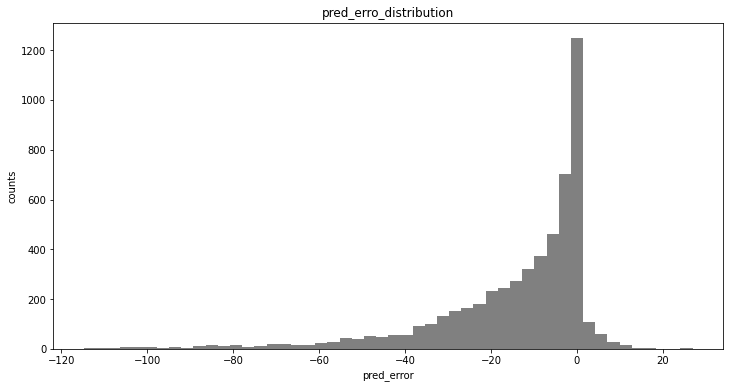


展示部分test_set上的拟合效果
        y_test  y_test_pred
0  1007.599976  1002.127991
1   907.799988   900.916016
2   808.000000   805.642517
3   708.200012   703.091431
4   658.400024   663.802795


测试集平均损失: 578.3476



,y_test,y_test_pred
0,1007.599976,1002.127991
1,907.799988,900.916016
2,808.000000,805.642517
3,708.200012,703.091431
4,658.400024,663.802795
...,...,...
5426,1.000000,54.690392
5427,0.800000,51.573284
5428,0.800000,48.535145
5429,0.600000,45.759113


In [16]:
model = LSTMResNet(num_features=3, hidden_size=64, num_layers=2, output_size=1, num_residual_blocks=5)
train_loader, va_loader, test_loader = LoadData(data_IO_C_all, sequence_length=10)
args = Args()
args.lr=0.001
model = train(model, train_loader, va_loader, args)
TEST(test_loader, args, model)